 # Scenario 2.1 - Pharmapendium Visual Analytics


In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install --quiet wordcloud
!{sys.executable} -m jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyter-matplotlib


Building jupyterlab assets (build:prod:minimize)


In [2]:
# python imports
import pprint
import uuid

from IPython.display import Markdown, display, HTML
from ipywidgets import widgets


In [ ]:
#  import spark related modules
import pyspark
import socket
from pyspark.sql import SparkSession
from pyspark import SparkContext, StorageLevel



# prevent error on rerunning if session is still alive
if 'sc' in globals():
    sc.stop()
    
# most configuration of the sparksession is done for you in the back
application_name = '2.1 - PP Visual Analytics'

sparkSession = SparkSession.builder.appName(application_name)\
                           .config('spark.executor.memory', '4g')\
                           .config('spark.executor.instances', '5')\
                           .config('spark.sql.shuffle.partitions', '50')\
                           .config('spark.driver.memory', '4g')\
                           .config('spark.executor.cores', '3')\
                           .config('spark.driver.host', socket.gethostbyname(socket.gethostname()))\
                           .getOrCreate()

sc = sparkSession.sparkContext
sc

In [ ]:
# pyspark imports

from pyspark.sql.functions import broadcast
from pyspark.sql.functions import upper
from pyspark.sql.functions import lower
from pyspark.sql.functions import explode
from pyspark.sql.functions import col
from pyspark.sql.functions import split
from pyspark.sql.functions import countDistinct


 ## Data loading and cleaning ##
 The datasets loaded are:
  - Drug
  - Study
  - Study design
  - Subjects
  - Species
  - Measure
  - PK Parameters
  - Results
  - Dosing Regimen
  
 ## Data schema ##
 

In [ ]:
from IPython.display import Image
Image("ppplus.png")

In [ ]:
# constants

hdfs_path = "hdfs://demo-full-load-hdfs-namenode:8020"

In [ ]:
# tables in use for this usecase

def dosing_regimen_df():
    file_path = hdfs_path + '/ppplus/elsevier-csv-ppplus-dosingregimen_deduplicated/*.csv'
    return sparkSession \
            .read \
            .option("header","true") \
            .csv(file_path) \
            .select(["DosingRegimen","hasDrug", "hasDose", "hasRoute"])\
            .dropDuplicates(['DosingRegimen'])


def drug_df():
    file_path = hdfs_path + '/ppplus/elsevier-csv-ppplus-drug_deduplicated/*.csv'
    return sparkSession \
            .read \
            .option("header","true") \
            .csv(file_path) \
            .select(["Drug","hasName","hasDrugClass", "hasFormula", "hasSmiles", "hasBrandNames", "hasChemicalNames"]) \
            .withColumnRenamed('hasName','drugName')\
            .dropDuplicates(['Drug'])


def drug_class_df():
    file_path = hdfs_path + '/ppplus/elsevier-csv-ppplus-drugclass_deduplicated/*.csv'
    return sparkSession \
            .read \
            .option("header","true") \
            .csv(file_path) \
            .select(["DrugClass", "core_prefLabel"])\
            .withColumnRenamed("core_prefLabel", "drugClassName") \
            .dropDuplicates(['DrugClass'])


def drug_indication_df():
    file_path = hdfs_path + '/ppplus/elsevier-csv-ppplus-drugindication_deduplicated/*.csv'
    return sparkSession \
            .read \
            .option("header","true") \
            .csv(file_path) \
            .select(["DrugIndication","hasIndication","hasSourceText", "hasSourceShort", "hasDrug"]) \
            .dropDuplicates(["DrugIndication"])


def efficacy_measure_df():
    return measure_df()\
        .select(["Measure","hasEndpoint","hasEndpointHigh","hasEndpointLow", "hasEndpointType", "hasPathogen","hasResult","hasParameterDisplay","hasAnalysisTechnique"])\
            .dropna(subset=["hasEndpoint"])\
            .dropDuplicates(['Measure'])


def effect_df():
    file_path = hdfs_path + '/ppplus/elsevier-csv-ppplus-effect_deduplicated/*.csv'
    return sparkSession \
            .read \
            .option("header","true") \
            .csv(file_path) \
            .select(["Effect", "core_prefLabel"])\
            .withColumnRenamed("core_prefLabel", "effectName") \
            .dropDuplicates(["Effect"])


def endpoint_df():
    file_path = hdfs_path + '/ppplus/elsevier-csv-ppplus-endpoint_deduplicated/*.csv'
    return sparkSession \
            .read \
            .option("header","true") \
            .csv(file_path) \
            .select(["Endpoint", "core_prefLabel"])\
            .withColumnRenamed('core_prefLabel','endpointName')


def indication_df():
    file_path = hdfs_path + '/ppplus/elsevier-csv-ppplus-indication_deduplicated/*.csv'
    return sparkSession \
            .read \
            .option("header","true") \
            .csv(file_path) \
            .select(["Indication", "core_prefLabel"])\
            .withColumnRenamed('core_prefLabel','indicationName')


def measure_df():
    file_path = hdfs_path + '/ppplus/elsevier-csv-ppplus-measure_deduplicated/*.csv'
    return sparkSession \
            .read \
            .option("header","true") \
            .csv(file_path) \
            .dropna(subset=["hasResult"])


def pk_measure_df():
    return measure_df()\
        .select(["Measure","hasPKParameter","hasPathogen","hasResult","hasParameterDisplay","hasAnalysisTechnique"])\
            .dropna(subset=["hasPKParameter"]) \
            .dropDuplicates(['Measure'])


def pk_parameter_df():
    file_path = hdfs_path + '/ppplus/elsevier-csv-ppplus-pkparameter_deduplicated/*.csv'
    return sparkSession \
            .read \
            .option("header","true") \
            .csv(file_path) \
            .select(["PKParameter","core_prefLabel"])\
            .withColumnRenamed('core_prefLabel','parameterName') \
            .dropDuplicates(['PKParameter'])


def result_df():
    file_path = hdfs_path + '/ppplus/elsevier-csv-ppplus-result_deduplicated/*.csv'
    return sparkSession \
            .read \
            .option("header","true") \
            .csv(file_path) \
            .select(["Result", "hasDisplayValue", "hasValue", "hasUnit", "haspValue", "hasAdverseEffect"])



def species_df():
    file_path = hdfs_path + '/ppplus/elsevier-csv-ppplus-species_deduplicated/*.csv'
    return sparkSession \
            .read \
            .option("header","true") \
            .csv(file_path) \
            .select(["Species", "core_prefLabel"])\
            .withColumnRenamed("core_prefLabel", "speciesName") \
            .dropDuplicates(['Species'])

def study_df():
#   ["Study","hasStudyDesign","hasDosingRegimen","hasMeasure","hasReference","hasRecordDateCreated"]
    file_path = hdfs_path + '/ppplus/elsevier-csv-ppplus-study_deduplicated/*.csv'
    return sparkSession \
            .read \
            .option("header","true") \
            .csv(file_path) \
            .select(["Study","hasStudyDesign","hasDosingRegimen","hasMeasure"]) \
            .dropna(subset=["hasStudyDesign"])\
            .dropDuplicates(['Study'])

def study_design_df():
#   ["StudyDesign","hasInteractingDrug","hasConcomitant","hasSubject","hasTarget","hasStudyNumber","hasStudyName","hasComment"]
    file_path = hdfs_path + '/ppplus/elsevier-csv-ppplus-studydesign_deduplicated/*.csv'
    return sparkSession \
            .read \
            .option("header","true") \
            .csv(file_path) \
            .select(["StudyDesign","hasInteractingDrug","hasConcomitant","hasSubject","hasStudyNumber","hasStudyName", "hasIndication"])\
            .dropna(subset=["hasInteractingDrug", "hasConcomitant"], thresh=1) \
            .dropDuplicates(['StudyDesign'])

def studies_for_drug_class(drug_class_df):
    studies = study_df()
    study_designs = study_design_df()
    
    studies = studies.join(study_designs, studies.hasStudyDesign == study_designs.StudyDesign, "left")
    
    dosing_regimen = dosing_regimen_df()
    studies = studies.join(dosing_regimen, studies.hasDosingRegimen == dosing_regimen.DosingRegimen,"inner")
    
    studies_w_class = studies.join(drug_class_df, studies.hasDrug == drug_class_df.Drug, "inner")
    
    return studies_w_class


def subject_df():
    file_path = hdfs_path + '/ppplus/elsevier-csv-ppplus-subject_deduplicated/*.csv'
    return sparkSession \
            .read \
            .option("header","true") \
            .csv(file_path) \
            .select(["Subject","hasSex","hasDisplayAge","hasSex","hasSpecies"])\
            .dropDuplicates(['Subject'])

In [ ]:
def drug_class_widget():
    classes = drug_class_df().drop_duplicates(subset=["DrugClass"]).toPandas().sort_values(by=["drugClassName"])
    
    classes_options = [tuple(x) for x in classes[['drugClassName', 'DrugClass']].values]
    
    return widgets.Dropdown(
        options=classes_options,
        description='Drug Classes'
    )

def species_widget():
    species = species_df().drop_duplicates(subset=["Species"]).toPandas().sort_values(by=["speciesName"])
    
    species = [tuple(x) for x in species[['speciesName', 'Species']].values]
    
    return widgets.Dropdown(
        options=species,
        description='Species'
    )

In [ ]:
PK_MODULE = "Pharmacokinetics"
EFFICACY_MODULE = "Efficacy"
SAFETY_MODULE = "Safety"


def module_widget():
    
    classes_options = [PK_MODULE, EFFICACY_MODULE, SAFETY_MODULE]
    
    return widgets.Dropdown(
        options=classes_options,
        description='Module'
    )

In [ ]:
import logging

pyspark_log = logging.getLogger('pyspark').setLevel(logging.ERROR)
py4j_logger = logging.getLogger("py4j").setLevel(logging.ERROR)

loggers = {}

def get_logger(logger_name):
        # create logger for prd_ci
        if loggers.get(logger_name):
            return loggers.get(logger_name)
        else:
            log = logging.getLogger(logger_name)
            log.setLevel(level=logging.INFO)

            # create formatter and add it to the handlers
            formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')


            # reate console handler for logger.
            ch = logging.StreamHandler()
            ch.setLevel(level=logging.INFO)
            ch.setFormatter(formatter)

            log.addHandler(ch)
            loggers[logger_name] = log
            return log
        


In [ ]:
import abc


class PPModule(abc.ABC):
    """Base class for various modules, dictates common interface"""

    @abc.abstractmethod
    def get_plot_config() -> dict:
        raise NotImplementedError
        
    @abc.abstractmethod
    def pretty():
        raise NotImplementedError
        
    def get_drugs_for_drug_class(self, drug_class_uri):
        drugs = drug_df()
        return drugs.filter(drugs.hasDrugClass.contains(drug_class_uri))
    
    def get_studies_for_drug_class(self, drug_class_df):
        return studies_for_drug_class(drug_class_df)
    
    def get_studies_for_drug_class_uri(self, drug_class_uri):
        drugs_from_class = self.get_drugs_for_drug_class(drug_class_uri)
        return self.get_studies_for_drug_class(drugs_from_class)
    
    @abc.abstractmethod
    def join_module_measures(self, studies_df):
        raise NotImplementedError

    def get_module_records(self, drug_class_uri):
        studies = self.get_studies_for_drug_class_uri(drug_class_uri)
        return self.join_module_measures(studies)




class PKModule(PPModule):
    """Contains fns to fetch PK data"""
    def __init__(self):
        
        self.logger = get_logger("pk-module")
        self.logger.info("PK Module ready.")
        
    def get_plot_config(self) -> dict:
        return {
            "plot_type": "box",
            'Y': 'hasValue',
            'X': 'hasUnit',
            "clean": True,
            'filter': {
                'name_field': 'parameterName',
                'uri_field': 'PKParameter'
            }
        }
        
    
    def join_module_measures(self, studies_df):
        """For PK we are interested in PK parameters"""
        self.logger.info("Merging measures onto studies...")
        pk_measures = pk_measure_df()
        studies = studies_df.join(pk_measures, studies_df.hasMeasure == pk_measures.Measure, "inner") \
                            .drop(*["hasMeasure"])
        
        
        self.logger.info("Merging PK parameters onto studies...")
        pk_params = pk_parameter_df()
        studies = studies.join(pk_params, studies.hasPKParameter == pk_params.PKParameter, "inner") \
                            .drop(*["hasPKParameter"])
        
        self.logger.info("Merging results onto studies...")
        results_table = result_df()
        studies = studies.join(results_table, studies.hasResult == results_table.Result, "inner")\
                            .drop(*["hasResult"])
        
        self.logger.info("Retrieving records...")
        studies_df = studies.toPandas()
        
        self.logger.info("Returning {} records...".format(len(studies_df)))
        
        return studies_df

    def pretty(self, records, n=20):
        records = records[
                ["drugName", "hasSmiles", "hasFormula", "hasStudyNumber", "hasStudyName", "hasDose", 
                 "parameterName", "hasDisplayValue", "hasValue", "hasUnit"]
        ].rename(columns={
            "drugName": "Drug",
            "hasSmiles": "SMILES",
            "hasFormula": "Chemical Formulat",
            "hasStudyNumber": "Study Number",
            "hasStudyName": "Study Name",
            "hasDose": "Dose",
            "parameterName": "Parameter",
            "hasDisplayValue": "Parameter Value",
            "hasValue": "Value",
            "hasUnit": "Unit"
        }).sort_values(by=["Drug", "Parameter"]).reset_index(drop=True)

        return display({'text/html': records.head(n).to_html()}, raw=True)
    


class EfficacyModule(PPModule):
    """Contains methods to fetch Efficacy data"""
    def __init__(self):
        
        self.logger = get_logger("efficacy-module")
        self.logger.info("Efficacy Module ready.")
    
    def get_plot_config(self) -> dict:
        return {
            "plot_type": "box",
            'Y': 'haspValue',
            'X': None,
            "clean": True,
            'filter': {
                'name_field': 'endpointName',
                'uri_field': 'Endpoint'
            }
        }
    
    def join_module_measures(self, studies_df):
        """For Efficacy we are interested in Endpoints"""
        self.logger.info("Merging Measures onto studies...")
        efficacy_measures = efficacy_measure_df()
        studies = studies_df.join(efficacy_measures, studies_df.hasMeasure == efficacy_measures.Measure, "inner") \
                            .drop(*["hasMeasure"])

        indications = indication_df()
        studies = studies.join(indications, studies.hasIndication == indications.Indication, "left")\
                        .drop(*["hasIndication"])

        self.logger.info("Merging Subjects onto studies...")
        subjects = subject_df()
        studies = studies.join(subjects, studies.hasSubject == subjects.Subject, "left")\
                            .drop(*["hasSubject"])
        
        species = species_df()
        studies = studies.join(species, studies.hasSpecies == species.Species, "left")\
                            .drop(*["hasSpecies"])
        
        self.logger.info("count: {}".format(studies.count()))
        
        self.logger.info("Merging Endpoints onto studies...")
        endpoints = endpoint_df()
        studies = studies.join(endpoints, studies.hasEndpoint == endpoints.Endpoint, "inner") \
                            .drop(*["hasEndpoint"])
        
        self.logger.info("Merging Results onto studies...")
        results_table = result_df()
        studies = studies.join(results_table, studies.hasResult == results_table.Result, "left")\
                            .drop(*["hasResult"])
        
        self.logger.info("Retrieving records...")
        studies_df = studies.toPandas()
        
        self.logger.info("Returning {} records...".format(len(studies_df)))
        
        return studies_df

    def pretty(self, records, n=20):
        records = records[
                ["drugName", "hasSmiles", "hasFormula", "hasStudyNumber", "hasStudyName", "speciesName", "hasSex",
                 "hasDisplayAge", "hasDose", "indicationName", "hasEndpointType", "endpointName", "hasDisplayValue", "hasValue", 
                 "hasUnit", "haspValue"]
        ].rename(columns={
            "drugName": "Drug",
            "hasSmiles": "SMILES",
            "hasFormula": "Chemical Formula",
            "hasStudyNumber": "Study Number",
            "hasStudyName": "Study Name",
            "speciesName": "Species",
            "hasSex": "Sex",
            "hasDisplayAge": "Age",
            "hasDose": "Dose",
            "hasEndpointType": "Endpoint Type",
            "endpointName": "Endpoint",
            "hasDisplayValue": "Display Value",
            "hasValue": "Value",
            "haspValue": "PValue",
            "hasUnit": "Unit"
        }).sort_values(by=["Drug", "Endpoint"]).reset_index(drop=True)

        return display({'text/html': records.head(n).to_html()}, raw=True)
    

    
class SafetyModule(PPModule):
    """Contains methods to fetch Efficacy data"""
    def __init__(self):
        
        self.logger = get_logger("safety-module")
        self.logger.info("Safety Module ready.")
        
    def get_plot_config(self) -> dict:
        return {
            "plot_type": "bar",
            "clean": False,
            'Y': 'effectName',
            "filter": None
        }
    
    def join_module_measures(self, studies_df):
        """For Efficacy we are interested in Endpoints"""
        
        measures = measure_df().select(["Measure", "hasResult"])
        
        studies = studies_df.join(measures, studies_df.hasMeasure == measures.Measure, "inner") \
                            .drop(*["hasMeasure"])
        
        self.logger.info("Merging Results onto studies...")
        results_table = result_df().select(["Result", "hasAdverseEffect"]).dropna(subset=["hasAdverseEffect"])
        
        studies = studies.join(results_table, studies.hasResult == results_table.Result, "inner")

        effects = effect_df()
        studies = studies.join(effects, results_table.hasAdverseEffect == effects.Effect, "inner")\
                            .drop(*["hasResult", "hasAdverseEffect"])
        
        self.logger.info("Merging Subjects onto studies...")
        subjects = subject_df().dropna(subset=["hasSpecies"])
        studies = studies.join(subjects, studies.hasSubject == subjects.Subject, "left")\
                            .drop(*["hasSubject"])
        
        species = species_df()
        studies = studies.join(species, studies.hasSpecies == species.Species, "left")\
                            .drop(*["hasSpecies"])
        
        self.logger.info("Retrieving records...")
        studies_df = studies.toPandas()
        
        self.logger.info("Returning {} records...".format(len(studies_df)))
        
        return studies_df
    
    def pretty(self, records, n=20):
        records = records[
                ["drugName", "effectName", "speciesName", "hasDose"]
            ].rename(columns={
                "drugName": "Drug",
                "effectName": "Adverse Effect",
                "speciesName": "Species",
                "hasDose": "Dose"
            }).sort_values(by=["Drug", "Adverse Effect"]).reset_index(drop=True)
                                  
        return display({'text/html': records.head(n).to_html()}, raw=True)
    
    
def get_module_for_selection(selection):
    """returns appropriate module for selection"""
    if selection == PK_MODULE:
        return PKModule()
    elif selection == EFFICACY_MODULE:
        return EfficacyModule()
    elif selection == SAFETY_MODULE:
        return SafetyModule()
    


### Select Module

In [ ]:
module_selector = module_widget()
display(module_selector)

In [13]:
chosen_module = get_module_for_selection(module_selector.value)

2020-09-09 12:25:24,824 - pk-module - INFO - PK Module ready.


### Get records

Select a drug class and inspect some results from the chosen module


In [14]:
drug_class_dropdown = drug_class_widget()
display(drug_class_dropdown)

Dropdown(description='Drug Classes', options=(('5-alpha-reductase inhibitors', 'https://data.elsevier.com/life…

In [16]:
drug_records = chosen_module.get_module_records(drug_class_dropdown.value)
drug_records.columns

2020-09-09 12:27:16,313 - pk-module - INFO - Merging measures onto studies...
2020-09-09 12:27:16,810 - pk-module - INFO - Merging PK parameters onto studies...
2020-09-09 12:27:17,264 - pk-module - INFO - Merging results onto studies...
2020-09-09 12:27:17,884 - pk-module - INFO - Retrieving records...
2020-09-09 12:28:51,285 - pk-module - INFO - Returning 37711 records...


Index(['Study', 'hasStudyDesign', 'hasDosingRegimen', 'StudyDesign',
       'hasInteractingDrug', 'hasConcomitant', 'hasSubject', 'hasStudyNumber',
       'hasStudyName', 'hasIndication', 'DosingRegimen', 'hasDrug', 'hasDose',
       'hasRoute', 'Drug', 'drugName', 'hasDrugClass', 'hasFormula',
       'hasSmiles', 'hasBrandNames', 'hasChemicalNames', 'Measure',
       'hasPathogen', 'hasParameterDisplay', 'hasAnalysisTechnique',
       'PKParameter', 'parameterName', 'Result', 'hasDisplayValue', 'hasValue',
       'hasUnit', 'haspValue', 'hasAdverseEffect'],
      dtype='object')

In [17]:
chosen_module.pretty(drug_records, n=10)

,Drug,SMILES,Chemical Formulat,Study Number,Study Name,Dose,Parameter,Parameter Value,Value,Unit
0,Clomiphene Citrate,OC(=O)CC(O)(CC(O)=O)C(O)=O.CCN(CC)CCOC1=CC=C(C=C1)C(\C1=CC=CC=C1)=C(/Cl)C1=CC=CC=C1,C32H36ClNO8,None,None,50 mg,AUC,65.0 ng*h/mL,65,ng*h/mL
1,Clomiphene Citrate,OC(=O)CC(O)(CC(O)=O)C(O)=O.CCN(CC)CCOC1=CC=C(C=C1)C(\C1=CC=CC=C1)=C(/Cl)C1=CC=CC=C1,C32H36ClNO8,None,None,50 mg,AUC,56.0 ng*h/mL,56,ng*h/mL
2,Clomiphene Citrate,OC(=O)CC(O)(CC(O)=O)C(O)=O.CCN(CC)CCOC1=CC=C(C=C1)C(\C1=CC=CC=C1)=C(/Cl)C1=CC=CC=C1,C32H36ClNO8,None,None,50 mg,AUC,60.0 ng*h/mL,60,ng*h/mL
3,Clomiphene Citrate,OC(=O)CC(O)(CC(O)=O)C(O)=O.CCN(CC)CCOC1=CC=C(C=C1)C(\C1=CC=CC=C1)=C(/Cl)C1=CC=CC=C1,C32H36ClNO8,None,None,50 mg,AUC,931.0 ng*h/mL,931,ng*h/mL
4,Clomiphene Citrate,OC(=O)CC(O)(CC(O)=O)C(O)=O.CCN(CC)CCOC1=CC=C(C=C1)C(\C1=CC=CC=C1)=C(/Cl)C1=CC=CC=C1,C32H36ClNO8,None,None,50 mg,AUC,1540.0 ng*h/mL,1540,ng*h/mL
5,Clomiphene Citrate,OC(=O)CC(O)(CC(O)=O)C(O)=O.CCN(CC)CCOC1=CC=C(C=C1)C(\C1=CC=CC=C1)=C(/Cl)C1=CC=CC=C1,C32H36ClNO8,None,None,50 mg,AUC,976.0 ng*h/mL,976,ng*h/mL
6,Clomiphene Citrate,OC(=O)CC(O)(CC(O)=O)C(O)=O.CCN(CC)CCOC1=CC=C(C=C1)C(\C1=CC=CC=C1)=C(/Cl)C1=CC=CC=C1,C32H36ClNO8,None,None,50 mg,AUC,1289.0 ng*h/mL,1289,ng*h/mL
7,Clomiphene Citrate,OC(=O)CC(O)(CC(O)=O)C(O)=O.CCN(CC)CCOC1=CC=C(C=C1)C(\C1=CC=CC=C1)=C(/Cl)C1=CC=CC=C1,C32H36ClNO8,None,None,50 mg,AUC,69.0 ng*h/mL,69,ng*h/mL
8,Clomiphene Citrate,OC(=O)CC(O)(CC(O)=O)C(O)=O.CCN(CC)CCOC1=CC=C(C=C1)C(\C1=CC=CC=C1)=C(/Cl)C1=CC=CC=C1,C32H36ClNO8,None,None,50 mg,Cmax,5.0 ng/mL,5,ng/mL
9,Clomiphene Citrate,OC(=O)CC(O)(CC(O)=O)C(O)=O.CCN(CC)CCOC1=CC=C(C=C1)C(\C1=CC=CC=C1)=C(/Cl)C1=CC=CC=C1,C32H36ClNO8,None,None,50 mg,Cmax,9.4 ng/mL,9.4,ng/mL


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt


class PlotUtility():
    def __init__(self, drug_records, plot_config):
        self.config = {}
        self._set_plot_config(plot_config)
        
        self.drug_records = self.clean_records(drug_records.copy())
        
        self.drug_filter = None
        self.parameter_filter = None
        
        self.populate_filters(self.drug_records)
        
    def _set_plot_config(self, new_config):
        self.config = new_config
        
    def clean_records(self, records):
        """ensures hasValue column is of type float"""
        column = self.config.get('Y')
        def _clean(row):
            try:
                row[column] = float(row[column])
                return row
            except ValueError:
                row[column] = None
                return row
            except TypeError:
                row[column] = None
                return row
        if self.config.get("clean"):
            records = records.apply(lambda x: _clean(x), axis=1)
        records = records.dropna(subset=[column])
        return records
    
    def populate_drug_filter(self, records):
        info = records[["Drug", "drugName"]].drop_duplicates().sort_values(by=["drugName"])
        
        options = [tuple(x) for x in info[["drugName", "Drug"]].values]

        return widgets.Dropdown(
            options=options,
            description='Drug'
        )
    
    def populate_parameter_filter(self, records):
        
        parameter_uri_label = self.config.get("filter").get("uri_field")
        parameter_label = self.config.get("filter").get("name_field")
        
        info = records[[parameter_uri_label, parameter_label]].drop_duplicates().sort_values(by=[parameter_label])
        
        options = [tuple(x) for x in info[[parameter_label, parameter_uri_label]].values]

        return widgets.Dropdown(
            options=options,
            description='Parameter'
        )

    def populate_filters(self, records):
        """looks at parameter column and populates filter"""
        items = []
        # there is always a Drug filter
        self.drug_filter = self.populate_drug_filter(records)
        items += [self.drug_filter]
        
        if self.config.get("plot_type") != "bar":
            self.parameter_filter = self.populate_parameter_filter(records)
            items += [self.parameter_filter]

        plot_widgets = widgets.HBox(items)
        return display(plot_widgets)

        
    def plot(self):
        """returns plot"""
        selection = self.drug_records[
            (self.drug_records["Drug"] == self.drug_filter.value)
        ]
        
        if self.config.get("filter") is not None:
            selection = selection[
                (selection[self.config.get('filter').get('uri_field')] == self.parameter_filter.value)
            ]
            
        if len(selection) < 3:
            print("Not enough data to plot...")
            return
        
        plt.figure(figsize=(14, 6))
        
        if (self.config.get("plot_type") == "box") and (self.config.get("X") is not None):
            x_col = self.config.get("X")
            y_col = self.config.get("Y")
            
            if self.config.get("X") is not None:
                box_plot = sns.boxplot(y=y_col, x=x_col, data=selection, width=0.3)
            else:
                box_plot = sns.boxplot(y=y_col, data=selection, width=0.3)

        elif self.config.get("plot_type") == "bar":
            
            values_counts = selection[self.config.get('Y')].value_counts()
            values_to_plot = values_counts[values_counts > 3]
            number_of_categories = len(values_to_plot)
            
            plt.figure(figsize=(6, 0.2*number_of_categories))
            bar_plot = sns.barplot(
                y=values_to_plot.index,
                x=values_to_plot)
        plt.show()

        
        

Add dropdown for unit selection

In [19]:
plot_utility = PlotUtility(drug_records, chosen_module.get_plot_config())

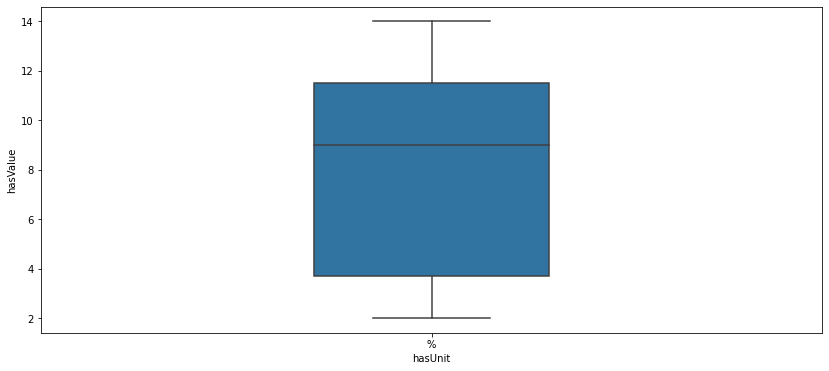

In [20]:
plot_utility.plot()

---

# Dashboard

In [13]:

# Utils widgets
from ipywidgets import Button, Layout, jslink, IntText, IntSlider

def create_expanded_button(description, button_style):
    return Button(description=description, button_style=button_style, layout=Layout(height='auto', width='auto'))


In [14]:
def get_drug_dropdown():
    drugs = drug_df().select(["Drug", "drugName"]).toPandas()
    info = drugs[["Drug", "drugName"]].drop_duplicates().sort_values(by=["drugName"])

    options = [tuple(x) for x in info[["drugName", "Drug"]].values]

    return widgets.Dropdown(
        options=options,
        description='Drug'
    )


In [15]:
from wordcloud import WordCloud
from collections import Counter
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn-dark-palette')

# from IPython.core.display import HTML
from ipywidgets import HTML, Layout
from ipywidgets import GridspecLayout

def get_assays_for_drug(drug_uri):
    drug_uri_broadcast = sc.broadcast(drug_uri)
    dosing_regimen = dosing_regimen_df()
    dose_for_drug = dosing_regimen.where(dosing_regimen.hasDrug == drug_uri_broadcast.value)
    
    studies = study_df()
    studies = studies.join(dose_for_drug, studies.hasDosingRegimen == dose_for_drug.DosingRegimen, "inner")
    
    study_designs = study_design_df()
    studies = studies.join(study_designs, studies.hasStudyDesign == study_designs.StudyDesign, "inner")
    
    subjects = subject_df().select(["Subject", "hasSpecies"])
    studies = studies.join(subjects, studies.hasSubject == subjects.Subject, "inner")
    
    species = species_df()
    studies = studies.join(species, studies.hasSpecies == species.Species, "inner")
    
    
    return studies



class Dashboard():
    def __init__(self, drug_uri):
        self.drug_uri = drug_uri
        self.drug = None
        
        self.assays_df = None
        self.drug_table = None
        self.drug_class_header = None
        self.brand_names_cloud = None
        self.species_by_assay = None
        
        self.grid = GridspecLayout(11, 4, height='1000px')
        
        self.setup_dashboard()
        
    def _plot_route_by_assay(self):
        route_assays = self.assays_df[["speciesName", "hasRoute"]].copy()
        
        route_assays['hasRoute'] = route_assays['hasRoute'].str.lower()
        
        plt.figure()
        bar_plot = sns.countplot(
                x="hasRoute",
                data=route_assays)  
        plt.show()
    
    def _plot_species_by_drug_assay(self):
        species_by_assay = self.assays_df['speciesName'].value_counts()
        
        fig, ax = plt.subplots(figsize=(4, 4), subplot_kw=dict(aspect="equal"))

        recipe = species_by_assay.index

        data = species_by_assay.values

        wedges, texts = ax.pie(data, wedgeprops=dict(width=0.3), startangle=-40)

        bbox_props = dict(boxstyle="square,pad=0.4", fc="w", ec="k", lw=0.72)
        kw = dict(arrowprops=dict(arrowstyle="-"),
                  bbox=bbox_props, zorder=0, va="center")

        for i, p in enumerate(wedges):
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = "angle,angleA=0,angleB={}".format(ang)
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                        horizontalalignment=horizontalalignment, **kw)

        ax.set_title("Species by Drug Assay")

        plt.show()
        
    def _set_filter_content(self):
        return
    
    def _set_drug_table_content(self):
        
        out = widgets.Output(layout=Layout(width='auto', height='auto', border='1px solid'))
        with out:
            display({'text/html': self.drug_table.T.to_html(header=False)}, raw=True)
        return out

    def _set_class_header(self):
        out = widgets.Output(layout=Layout(width='auto', height='auto', border='1px solid'))
        with out:
            display(HTML(self.drug_class_header))
        return out
    
    def _set_names_cloud(self):
        out = widgets.Output(layout=Layout(width='auto', height='auto', border='1px solid'))
        with out:
            plt.figure(figsize=(8,6))
            plt.imshow(self.brand_names_cloud, interpolation="bilinear")
            plt.axis("off")
            plt.show()
        return out

    def _set_species_by_assay(self):
        out = widgets.Output(layout=Layout(width='auto', height='auto', top="auto", border='1px solid'))
        with out:
            self._plot_species_by_drug_assay()
        return out
    
    def _set_route_by_assay(self):
        out = widgets.Output(layout=Layout(width='auto', height='auto', border='1px solid'))
        with out:
            self._plot_route_by_assay()
        return out
    
    def _set_assay_table(self):
        
        assay_table = self.assays_df[["hasDrug", "speciesName", "hasRoute", "hasDose", "hasStudyNumber", "hasStudyName"]]
        
        assay_table = assay_table.rename(columns={
            "hasDrug": "Drug",
            "speciesName": "Species",
            "hasRoute": "Route",
            "hasDose": "Dose",
            "hasStudyNumber": "Study Number",
            "hasStudyName": "Study Name"
        })
        
        out = widgets.Output(layout=Layout(width='auto', height='auto'))
        with out:
            display({'text/html': assay_table.to_html()}, raw=True)
        return out
    
    def _set_dashboard_content(self):
        self.grid[1:3, 0:2] = self._set_drug_table_content()
        self.grid[:1, 0:2] = self._set_class_header()
        self.grid[:3, 2:] = self._set_names_cloud()
        self.grid[3:7, :2] = self._set_species_by_assay()
        self.grid[3:7, 2:] = self._set_route_by_assay()
        self.grid[7:, :] = self._set_assay_table()
        display(self.grid)
    
    def get_drug_for_uri(self):
        drugs = drug_df()
        self.drug = drugs.where(drugs.Drug == self.drug_uri).toPandas()
        
    def get_drug_table(self):
        drug_table = self.drug[[
            "Drug", "drugName", "hasFormula", "hasSmiles", "hasChemicalNames"
        ]].copy()
        
        drug_table = drug_table.rename(columns={
            "Drug": "Drug URI",
            "drugName": "Drug",
            "hasFormula": "Chemical Formula",
            "hasSmiles": "SMILES",
            "hasChemicalNames": "Chemical Names"
        })

        self.drug_table = drug_table
    
    def get_brand_names(self):
        brand_names = self.drug.loc[0]['hasBrandNames'].split('||')
        
        cloud_entries = Counter(brand_names)

        # lower max_font_size
        self.brand_names_cloud = WordCloud(background_color="white", min_font_size=20).generate_from_frequencies(cloud_entries)

        
    def get_drug_class(self):
        drug_class_uris = self.drug.loc[0]["hasDrugClass"].split("||")
        drug_classes = drug_class_df()
        class_names = drug_classes.where(drug_classes.DrugClass.isin(drug_class_uris))\
                        .toPandas()["drugClassName"].values
        
        brand_strings = ["<h1 style='font-size:24px;color:#2C3E50;'>{}</h1>".format(x) for x in class_names][0]
        brand_strings = "".join(brand_strings)
        
        self.drug_class_header = brand_strings
        
    def get_assays(self):
        assays = get_assays_for_drug(self.drug_uri)
        self.assays_df = assays.toPandas()
        
    def setup_dashboard(self):
        self.get_drug_for_uri()
        self.get_drug_table()
        
        self.get_brand_names()
        
        self.get_drug_class()
        
        self.get_assays()
        
        self._set_dashboard_content()

        

In [16]:
drug_dropdown = get_drug_dropdown()
display(drug_dropdown)

Dropdown(description='Drug', options=(('1-13C-Caprylic Acid', 'https://data.elsevier.com/lifescience/entity/pp…

In [18]:
Dashboard(drug_dropdown.value)


GridspecLayout(children=(Output(layout=Layout(border='1px solid', grid_area='widget001', height='auto', width=…

<Figure size 432x288 with 0 Axes>

---